<a href="https://colab.research.google.com/github/takatakamanbou/Vision/blob/main/Vision2023_report02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision2023-report02

課題の期限や提出の方法などについては，別途お知らせしています



---
## 準備
---

---
### GPUを利用するようにランタイムのタイプを変更する



この notebook では，通常の Colab Notebook の動かし方では時間がかかる所があります．次のようにしてランタイムのタイプを変更し，より高速な計算ができるようにしましょう．

1. メニューの「ランタイム」 > 「ランタイムのタイプを変更」 を選択．
1. 「ノートブックの設定」というポップアップウィンドウが開くので，「ハードウェアアクセラレータ」を「None」から「GPU」に変更し，「保存」する
1. いつもどおりコードセルを実行する．すでに実行していた場合，「以前のランタイムを削除する」というポップアップウィンドウが現れるので，「OK」を押しし，一番最初のコードセルから実行し直ます．

Colab Notebook は Linux を OS とする PC （クラウド上の仮想マシン）で実行されます．
通常は，その実行は CPU 上で行われますが，上記のように設定を変更することで，一部の計算を GPU にまかせることができるようになります（注）．

<span style="font-size: 75%">
※注: 無料でできますが，計算時間等が制限されています．
</span>

GPU (Graphical Processing Unit) というのは，PCのグラフィックスボード／ビデオカードやゲーム機等に搭載される，画像処理に特化した演算装置です．CPUのような汎用性がない代わりに，特定の処理をCPUよりずっと高速に実行できます．
この notebook では PyTorch という深層学習フレームワークを使用しますが， PyTorch ではニューラルネットの出力や学習のための計算を GPU 上で行って高速化することが簡単にできるようになっています．

---
### いろいろ import

In [ ]:
# 準備あれこれ
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
seaborn.set()

In [ ]:
# PyTorch 関係のほげ
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import FashionMNIST
import torchsummary

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


GPU が使えるようになっていれば，↑のセルを実行すると `cuda:0` と出力されるはずです．


---
### データの準備

このレポート課題では，FashionMNIST という画像データセットを用いた識別の実験を行います．このデータセットは，28x28画素のグレイスケール画像10種類から成ります．

In [ ]:
# データ読み込みの仕組み
dsL = FashionMNIST(root='.', train=True, download=True, transform=ToTensor())
dsT = FashionMNIST(root='.', train=False, download=True, transform=ToTensor())
dlL = DataLoader(dsL, batch_size=100, shuffle=True)
dlT = DataLoader(dsT, batch_size=100, shuffle=False)
print(f'学習データ数: {len(dsL)}  テストデータ数: {len(dsT)}')

# クラス番号とクラス名
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

100%|██████████| 26421880/26421880 [00:00<00:00, 112752968.07it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 6057093.77it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 65544459.66it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19261620.87it/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw

学習データ数: 60000  テストデータ数: 10000


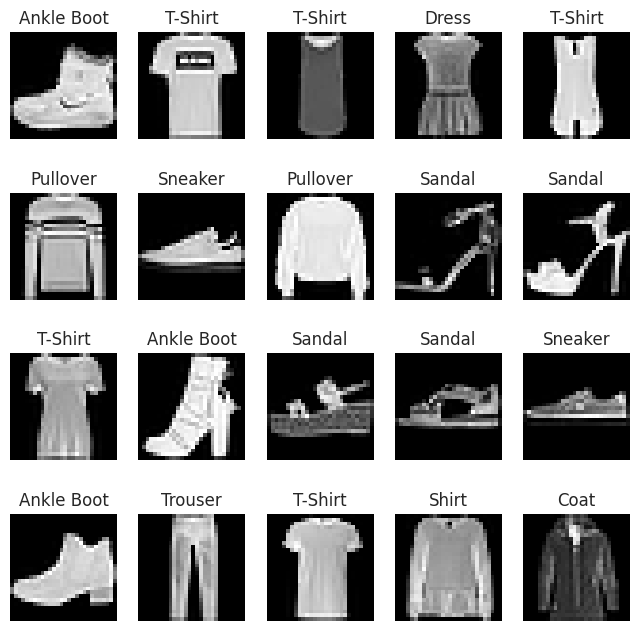

In [ ]:
# 一部データを可視化
nrow, ncol = 4, 5
fig = plt.figure(figsize=(8, 8))
for i in range(nrow*ncol):
    X, y = dsL[i]
    fig.add_subplot(nrow, ncol, i+1)
    plt.axis('off')
    plt.imshow(X.squeeze(), cmap='gray')
    plt.title(labels_map[y])
plt.show()

---
### 学習に用いるクラス・関数の定義

次の2つの関数は修正の必要はありません．

In [ ]:
# 1epoch の学習を行う関数
#
def train(model, lossFunc, optimizer, dl):
    loss_sum = 0.0
    ncorrect = 0
    n = 0
    for i, (X, lab) in enumerate(dl):
        X, lab = X.to(device), lab.to(device)
        Y = model(X)           # 一つのバッチ X を入力して出力 Y を計算
        loss = lossFunc(Y, lab) # 正解ラベル lab に対する loss を計算
        optimizer.zero_grad()   # 勾配をリセット
        loss.backward()         # 誤差逆伝播でパラメータ更新量を計算
        optimizer.step()         # パラメータを更新
        n += len(X)
        loss_sum += loss.item()  # 損失関数の値
        ncorrect += (Y.argmax(dim=1) == lab).sum().item()  # 正解数

    return loss_sum/n, ncorrect/n

In [ ]:
# 損失関数や識別率の値を求める関数
#
@torch.no_grad()
def evaluate(model, lossFunc, dl):
    loss_sum = 0.0
    ncorrect = 0
    n = 0
    for i, (X, lab) in enumerate(dl):
        X, lab = X.to(device), lab.to(device)
        Y = model(X)           # 一つのバッチ X を入力して出力 Y を計算
        loss = lossFunc(Y, lab)  # 正解ラベル lab に対する loss を計算
        n += len(X)
        loss_sum += loss.item() # 損失関数の値
        ncorrect += (Y.argmax(dim=1) == lab).sum().item()  # 正解数

    return loss_sum/n, ncorrect/n

---
## 問題1 ロジスティック回帰

FashionMNIST のデータをロジスティック回帰で識別する実験を行いましょう．
コードセルを順にそのまま実行してみてください．


In [ ]:
# ロジスティック回帰モデルを定義するクラス
#
class LogisticRegression(nn.Module):

    # コンストラクタ． D: 入力次元数， K: クラス数
    def __init__(self, D, K):
        super(LogisticRegression, self).__init__()
        self.flatten = nn.Flatten() # 4次元テンソルで与えられる入力を2次元にする変換
        self.fc = nn.Linear(D, K)  # 入力 => 出力層

    # モデルの出力を計算するメソッド
    def forward(self, X):
        X = self.flatten(X)
        X = self.fc(X)
        return X

In [ ]:
##### 学習の実行 #####

# ネットワークモデル
net = LogisticRegression(784, 10).to(device)
#torchsummary.summary(net, (1, 28, 28))
print(net)

# 損失関数（交差エントロピー）
loss_func = nn.CrossEntropyLoss(reduction='sum')

# パラメータ最適化器
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# 学習の繰り返し回数
nepoch = 20

# 学習
results = []
print('# epoch  lossL  lossT  rateL  rateT')
for t in range(1, nepoch+1):
    lossL, rateL = train(net, loss_func, optimizer, dlL)
    lossT, rateT = evaluate(net, loss_func, dlT)
    results.append([t, lossL, lossT, rateL, rateT])
    print(f'{t}   {lossL:.5f}   {lossT:.5f}   {rateL:.4f}   {rateT:.4f}')


LogisticRegression(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=784, out_features=10, bias=True)
)
# epoch  lossL  lossT  rateL  rateT
1   0.69922   0.55599   0.7722   0.8123
2   0.50002   0.50683   0.8323   0.8245
3   0.46301   0.48980   0.8440   0.8325
4   0.44423   0.47588   0.8484   0.8343
5   0.42976   0.46090   0.8525   0.8390
6   0.42176   0.45711   0.8560   0.8406
7   0.41479   0.45221   0.8573   0.8421
8   0.40915   0.45228   0.8590   0.8405
9   0.40428   0.44914   0.8607   0.8422
10   0.40102   0.46357   0.8612   0.8353
11   0.39754   0.44380   0.8628   0.8450
12   0.39534   0.44123   0.8639   0.8452
13   0.39196   0.44550   0.8642   0.8427
14   0.38994   0.44025   0.8652   0.8453
15   0.38860   0.44745   0.8647   0.8432
16   0.38691   0.43861   0.8663   0.8455
17   0.38462   0.44878   0.8659   0.8436
18   0.38396   0.44341   0.8670   0.8454
19   0.38256   0.44168   0.8668   0.8453
20   0.38075   0.44028   0.8678   0.8466


上記の
```
# epoch  lossL  lossT  rateL  rateT
```
の下の値は，左から順に学習繰り返し回数（エポック単位），学習データに対する損失関数の値，テストデータに対する同，学習データの識別率，テストデータに対する同，です．

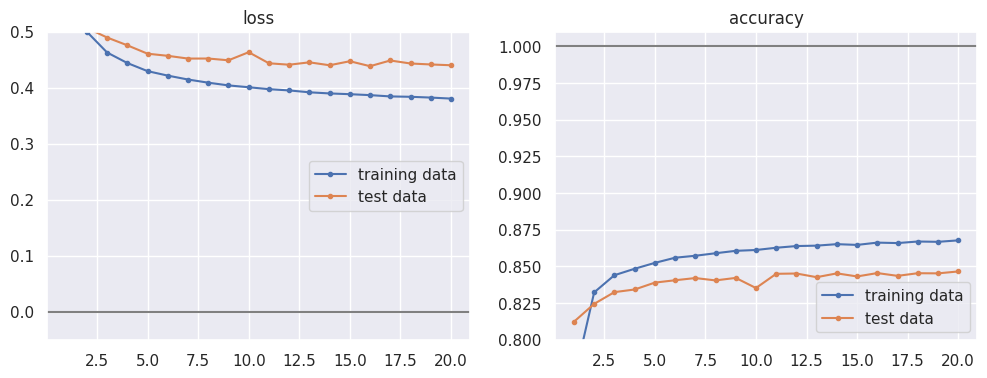

# 学習データに対する損失: 0.37531  識別率: 0.8693
# テストデータに対する損失: 0.44028  識別率: 0.8466


In [ ]:
##### 学習結果の表示 #####

# 学習曲線の表示
data = np.array(results)
fig, ax = plt.subplots(1, 2, facecolor='white', figsize=(12, 4))
ax[0].plot(data[:, 0], data[:, 1], '.-', label='training data')
ax[0].plot(data[:, 0], data[:, 2], '.-', label='test data')
ax[0].axhline(0.0, color='gray')
ax[0].set_ylim(-0.05, 0.5)
ax[0].legend()
ax[0].set_title(f'loss')
ax[1].plot(data[:, 0], data[:, 3], '.-', label='training data')
ax[1].plot(data[:, 0], data[:, 4], '.-', label='test data')
ax[1].axhline(1.0, color='gray')
ax[1].set_ylim(0.8, 1.01)
ax[1].legend()
ax[1].set_title(f'accuracy')
plt.show()

# 学習後の損失と識別率
loss2, rrate = evaluate(net, loss_func, dlL)
print(f'# 学習データに対する損失: {loss2:.5f}  識別率: {rrate:.4f}')
loss2, rrate = evaluate(net, loss_func, dlT)
print(f'# テストデータに対する損失: {loss2:.5f}  識別率: {rrate:.4f}')

上記のセルを実行して得られる2つのグラフを保存しておきましょう（右クリック → 名前をつけて画像を保存）．また，最後に出力される
```
# 学習データに対する損失: ...  識別率: ...
# テストデータに対する損失: ...  識別率: ...
```
の部分をコピペして保存しておきましょう．

パラメータの初期値が変われば結果も変わりますので，何度か実行し直してみるとよいでしょう．

---
## 問題2 2層ニューラルネット

隠れ層を1つだけ持つニューラルネットで問題1と同じ実験を行いましょう．



In [ ]:
# 2層ニューラルネットを定義するクラス
#
class MLP2(nn.Module):

    # コンストラクタ． D: 入力次元数， H: 隠れ層ニューロン数， K: クラス数
    def __init__(self, D, H, K):
        super(MLP2, self).__init__()
        # 4次元テンソルで与えられる入力を2次元にする変換
        self.flatten = nn.Flatten()
        # 入力 => 隠れ層
        self.fc1 = nn.Sequential(
            nn.Linear(D, H), nn.ReLU()
        )
        # 隠れ層 => 出力層
        self.fc2 = nn.Linear(H, K) # 出力層には活性化関数を指定しない

    # モデルの出力を計算するメソッド
    def forward(self, X):
        X = self.flatten(X)
        X = self.fc1(X)
        X = self.fc2(X)
        return X

↑のセルは実行するだけです．修正の必要はありません．

次のコードセルに，問題1の
```
##### 学習の実行 #####
```
のセルをコピペして，
```
net = LogisticRegression(784, 10).to(device)
```
の行を
```
net = MLP2(784, ???, 10).to(device)
```
に修正して実行しましょう． `???` には自然数を指定します．
`MLP2` クラスを定義しているコードセルの内容に基づいて，適当そうな値を選んでください．

In [ ]:
##### 学習の実行 #####




次のコードセルに，問題1の
```
##### 学習結果の表示 #####
```
のセルをコピペして実行しましょう．修正の必要はありません．

In [ ]:
##### 学習結果の表示 #####




`???` の値を何通りか試して，問題1と同様にグラフと結果の値を保存しておきましょう．

---
## 問題3 3層ニューラルネット

隠れ層を2つ持つニューラルネットで問題1と同じ実験を行いましょう．



In [ ]:
# 3層ニューラルネットを定義するクラス
#
class MLP3(nn.Module):

    # コンストラクタ． D: 入力次元数， H1, H2: 隠れ層ニューロン数， K: クラス数
    def __init__(self, D, H1, H2, K):
        super(MLP3, self).__init__()
        # 4次元テンソルで与えられる入力を2次元にする変換
        self.flatten = nn.Flatten()
        # 入力 => 隠れ層1
        self.fc1 = nn.Sequential(
            nn.Linear(D, H1), nn.ReLU()
        )
        ### 続きを自分で書いてね ###


上記のコードセルと，次の2つのコードセルの中身を書いて実験しましょう．
ニューロン数は適当に選んでください．

In [ ]:
##### 学習の実行 #####




In [ ]:
##### 学習結果の表示 #####




ニューロン数を何通りか試して，問題1と同様にグラフと結果の値を保存しておきましょう．

---
## 問題4 畳み込みニューラルネット

畳み込みニューラルネットで問題1と同じ実験を行いましょう．



- 畳み込みニューラルネットの構造は適当に自分で定めてください．他人のコードを参考にするのは構いませんが，理解せずに使うことはやめましょう．
- ネットワークを定義するクラスの名前は次の通り `CNN` としてください．コンストラクタの引数の設定などは任意です．

In [ ]:
# 畳み込みニューラルネットを定義するクラス
#
class CNN(nn.Module):
    

In [ ]:
##### 学習の実行 #####




In [ ]:
##### 学習結果の表示 #####




---
## 問題5 レポートにまとめる

今回は，次の二つのものを作成して提出してもらいます． 

1. この notebook を編集したもの
1. 実験結果の図や数値をまとめ，考察を記した文書

2.の方は，この授業の個別共有フォルダを開いた状態で，左上の「+ 新規」を押すか右クリックして「Google ドキュメント」を選択し，そこに書き込む形としてください．

実験1から実験4までの図や数値を整理してまとめ，それらに対する考察を行ってください．
